<a href="https://colab.research.google.com/github/rushanmukherjee/GeospatialDataAnalytics/blob/main/Enriching_Boundaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import geopandas as gpd

In [12]:
df = pd.read_csv('New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv')

In [13]:
df.head()

,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
0,Bronx,2000,5,BX01,Claremont-Bathgate,28149
1,Bronx,2000,5,BX03,Eastchester-Edenwald-Baychester,35422
2,Bronx,2000,5,BX05,Bedford Park-Fordham North,55329
3,Bronx,2000,5,BX06,Belmont,25967
4,Bronx,2000,5,BX07,Bronxdale,34309


In [14]:
len(df)

390

In [15]:
print(set(df.Year))

{2000, 2010}


In [16]:
df = df[df.Year == 2010]
len(df)

195

In [17]:
gdf = gpd.read_file('2010 Neighborhood Tabulation Areas (NTAs).geojson')

In [18]:
len(gdf)

195

In [19]:
display(gdf.head(1))
display(df.head(1))

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry
0,QN08,77412747.756,081,St. Albans,45401.3169155,Queens,4,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ..."


,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
195,Bronx,2010,5,BX01,Claremont-Bathgate,31078


In [20]:
nta_codes1 = set(gdf.ntacode)
nta_codes2 = set(df['NTA Code'])

In [21]:
len(nta_codes1), len(nta_codes2), len(nta_codes1.intersection(nta_codes2))

(195, 195, 195)

### Merge Dataframes


In [22]:
gdf_merged = gdf.merge(df, left_on='ntacode', right_on='NTA Code')
gdf_merged = gdf_merged[['ntacode', 'geometry', 'Population']]
gdf_merged.head(3)

,ntacode,geometry,Population
0,QN08,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ...",48593
1,BK50,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...",83693
2,BX41,"MULTIPOLYGON (((-73.89561 40.85457, -73.89662 ...",51807


### Visualize New Dataframe

(np.float64(-74.28337047814922),
 np.float64(-73.67222994821337),
 np.float64(40.47516404814219),
 np.float64(40.93650271647436))

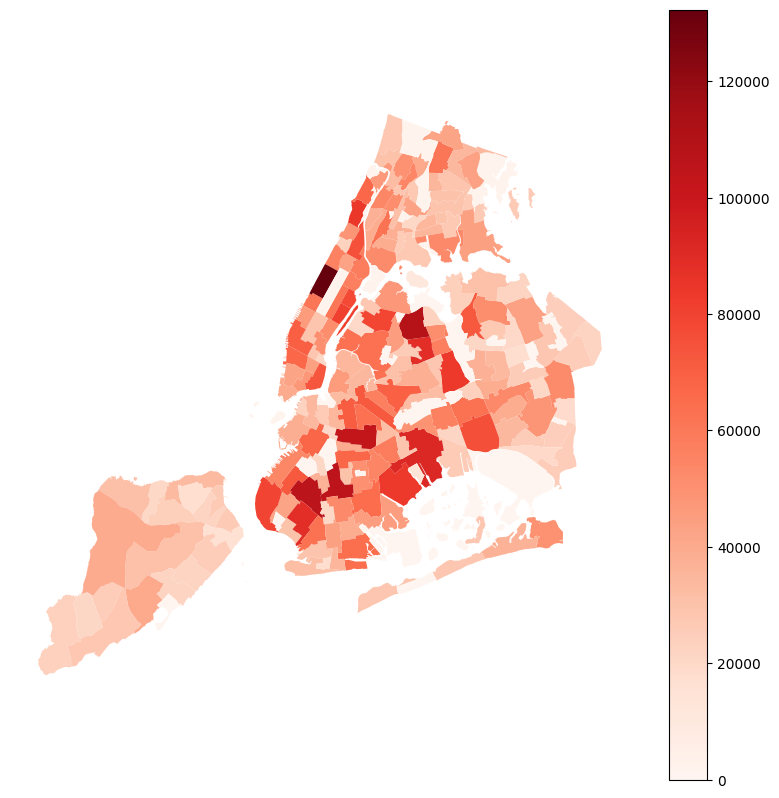

In [23]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(10, 10))
gdf_merged.plot(column='Population', ax=ax, legend=True, cmap = 'Reds')
ax.axis('off')

## Filter for Manhattan

In [24]:
gdf_merged_new = gdf.merge(df, left_on='ntacode', right_on='NTA Code')
gdf_manhattan = gdf_merged_new[gdf_merged_new.boro_name == 'Manhattan']
gdf_manhattan.head(3)

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
45,MN19,17390168.1386,061,Turtle Bay-East Midtown,21251.8414488,Manhattan,1,"MULTIPOLYGON (((-73.96052 40.74411, -73.96057 ...",Manhattan,2010,61,MN19,Turtle Bay-East Midtown,51231
47,MN04,15984383.0261,061,Hamilton Heights,17103.3632867,Manhattan,1,"MULTIPOLYGON (((-73.94035 40.83046, -73.94014 ...",Manhattan,2010,61,MN04,Hamilton Heights,48520
48,MN50,5575563.18924,061,Stuyvesant Town-Cooper Village,11061.8187289,Manhattan,1,"MULTIPOLYGON (((-73.96237 40.72421, -73.96201 ...",Manhattan,2010,61,MN50,Stuyvesant Town-Cooper Village,21049


In [25]:
gdf_manhattan_local = gdf_manhattan.to_crs(2263)
gdf_merged_new = gdf_merged_new.to_crs(2263)

<Axes: >

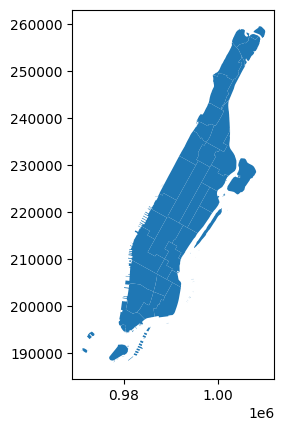

In [26]:
 gdf_manhattan_local.plot()

## Data Preparation

<Axes: >

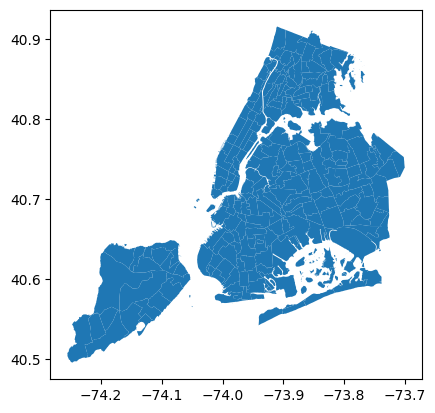

In [27]:
gdf_merged.plot()

### Transform Polygon map into Centroids

In [29]:
gdf_merged_local_points = gdf_merged_new.copy()
gdf_merged_local_points['geometry'] = [g.centroid for g in list(gdf_merged_local_points.geometry)]
gdf_merged_local_points.head(3)

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
0,QN08,77412747.756,081,St. Albans,45401.3169155,Queens,4,POINT (1049933.65 191188.479),Queens,2010,81,QN08,St. Albans,48593
1,BK50,82089678.5561,047,Canarsie,43703.6099368,Brooklyn,3,POINT (1012073.055 171748.235),Brooklyn,2010,47,BK50,Canarsie,83693
2,BX41,14716710.849,005,Mount Hope,18937.2480746,Bronx,2,POINT (1010498.971 248626.411),Bronx,2010,5,BX41,Mount Hope,51807


<Axes: >

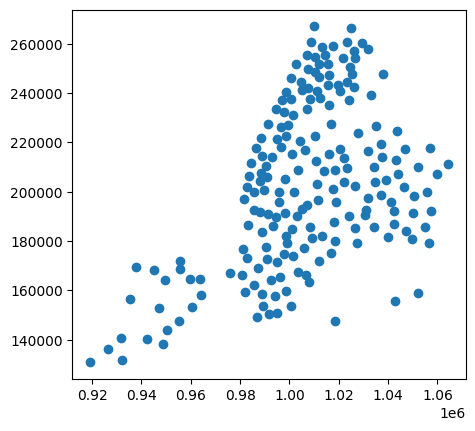

In [30]:
gdf_merged_local_points.plot()

### Calculate num people living within specific buffer size

<Axes: >

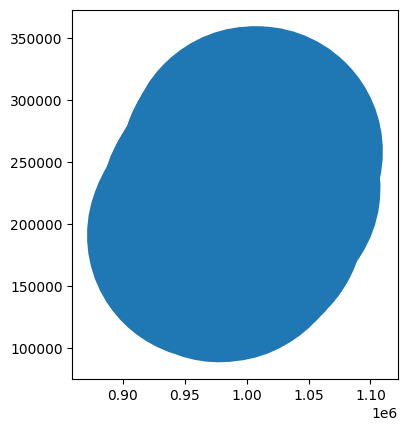

In [31]:
##Buffering
distance = 100000
gdf_manhattan_local_buffered = gdf_manhattan_local.copy()
gdf_manhattan_local_buffered['geometry'] = gdf_manhattan_local_buffered.geometry.buffer(distance)
gdf_manhattan_local_buffered.plot()

In [32]:
##Join Spatially
gdf_joined = gpd.sjoin(gdf_merged_local_points, gdf_manhattan_local_buffered)
gdf_joined.head(3)

,ntacode_left,shape_area_left,county_fips_left,ntaname_left,shape_leng_left,boro_name_left,boro_code_left,geometry,Borough_left,Year_left,...,ntaname_right,shape_leng_right,boro_name_right,boro_code_right,Borough_right,Year_right,FIPS County Code_right,NTA Code_right,NTA Name_right,Population_right
0,QN08,77412747.756,081,St. Albans,45401.3169155,Queens,4,POINT (1049933.65 191188.479),Queens,2010,...,Battery Park City-Lower Manhattan,43727.7254838,Manhattan,1,Manhattan,2010,61,MN25,Battery Park City-Lower Manhattan,39699
0,QN08,77412747.756,081,St. Albans,45401.3169155,Queens,4,POINT (1049933.65 191188.479),Queens,2010,...,Chinatown,20786.2546133,Manhattan,1,Manhattan,2010,61,MN27,Chinatown,47844
0,QN08,77412747.756,081,St. Albans,45401.3169155,Queens,4,POINT (1049933.65 191188.479),Queens,2010,...,Lower East Side,26820.9016081,Manhattan,1,Manhattan,2010,61,MN28,Lower East Side,72957


<Axes: >

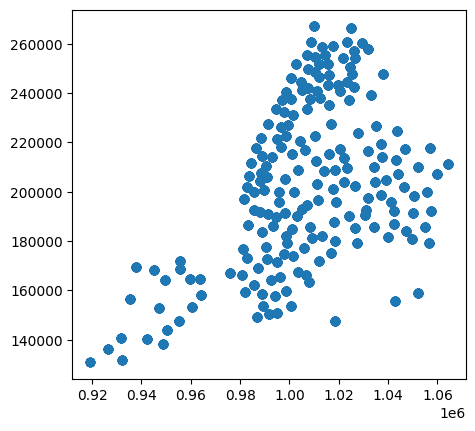

In [33]:
gdf_joined.plot()

In [34]:
##Compute The Population
print('Manhattan Population', sum(gdf_joined.Population_left))
print('Buffer Zone Population', sum(gdf_joined.Population_right))
print('Buffer to Manhattan Ratio', round(sum(gdf_joined.Population_left) /sum(gdf_joined.Population_right), 2))

Manhattan Population 234058179
Buffer Zone Population 302083724
Buffer to Manhattan Ratio 0.77


In [36]:
##Making the Ratio Calculation Better

def count_population_statistics(distance):

  ##Buffering
  gdf_manhattan_local_buffered = gdf_manhattan_local.copy()
  gdf_manhattan_local_buffered['geometry'] = gdf_manhattan_local_buffered.geometry.buffer(distance)
  gdf_manhattan_local_buffered.plot()

  ##Spatial Join
  gdf_joined = gpd.sjoin(gdf_merged_local_points, gdf_manhattan_local_buffered)

  ##Compute The Population
  print('Zone size:', distance, 'feet')
  print('Manhattan Population', sum(gdf_joined.Population_left))
  print('Buffer Zone Population', sum(gdf_joined.Population_right))
  print('Buffer to Manhattan Ratio', round(sum(gdf_joined.Population_left) /sum(gdf_joined.Population_right), 2))
  print()

In [37]:
distances = [100, 1000, 5000, 10000, 25000, 10000]

Zone size: 100 feet
Manhattan Population 1585873
Buffer Zone Population 1641926
Buffer to Manhattan Ratio 0.97

Zone size: 1000 feet
Manhattan Population 1797507
Buffer Zone Population 1966404
Buffer to Manhattan Ratio 0.91

Zone size: 5000 feet
Manhattan Population 11454568
Buffer Zone Population 11432763
Buffer to Manhattan Ratio 1.0

Zone size: 10000 feet
Manhattan Population 24556715
Buffer Zone Population 25297507
Buffer to Manhattan Ratio 0.97

Zone size: 25000 feet
Manhattan Population 71911298
Buffer Zone Population 79238550
Buffer to Manhattan Ratio 0.91

Zone size: 10000 feet
Manhattan Population 24556715
Buffer Zone Population 25297507
Buffer to Manhattan Ratio 0.97



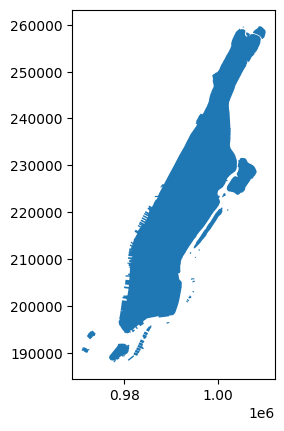

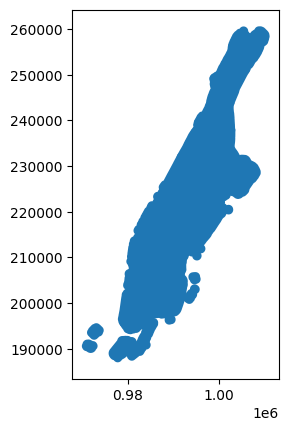

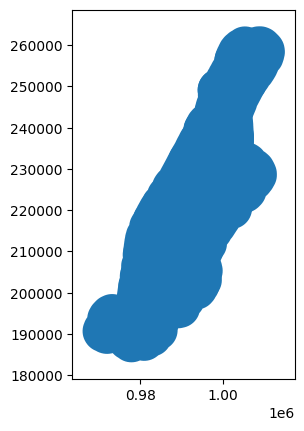

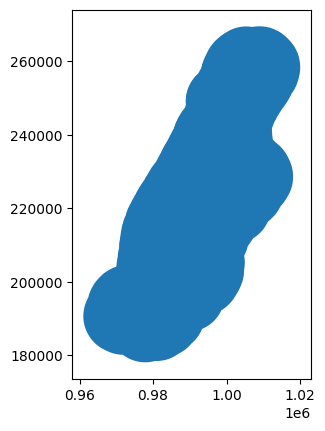

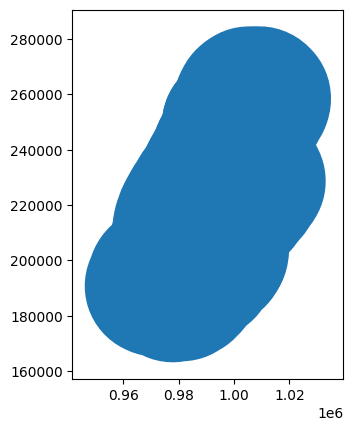

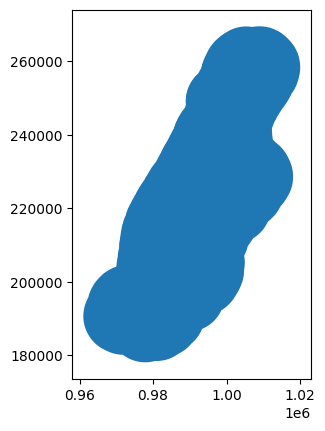

In [38]:
for distance in distances:
  count_population_statistics(distance)